In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/vision

/content/drive/MyDrive/vision


In [3]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=0af881313a6f21d0331fd46e9fdc3299299585d4a3cf0ae4f6e33760b6a98b71
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00


In [6]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
# from transformers import *
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

In [8]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [9]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

train_ner_df.head()

# 개체명 인식 학습 데이터 개수: 81000
# 개체명 인식 테스트 데이터 개수: 9000

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [11]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))
print(ner_labels)

개체명 인식 레이블 개수: 30
['UNK', 'O', 'PER-B', 'PER-I', 'FLD-B', 'FLD-I', 'AFW-B', 'AFW-I', 'ORG-B', 'ORG-I', 'LOC-B', 'LOC-I', 'CVL-B', 'CVL-I', 'DAT-B', 'DAT-I', 'TIM-B', 'TIM-I', 'NUM-B', 'NUM-I', 'EVT-B', 'EVT-I', 'ANM-B', 'ANM-I', 'PLT-B', 'PLT-I', 'MAT-B', 'MAT-I', 'TRM-B', 'TRM-I']


In [12]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

In [32]:
a = [1,2,3]
b = [4,5,6]
a.append(b)
print(a)

[1, 2, 3, [4, 5, 6]]


In [33]:
a = [1,2,3]
b = [4,5,6]
a.extend(b)
print(a)

[1, 2, 3, 4, 5, 6]


In [40]:
a = [9]*3 # [9]+[9]+[9]
print(a)

[9, 9, 9]


In [44]:
def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']

    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):

    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        # print('word=', word)             # '금석객잔'
        # print('slot_label=',slot_label)  #  8

        word_tokens = tokenizer.tokenize(word)

        # print('word_tokens=', word_tokens)

        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        # print('tokens=', tokens)

        # 금석객잔 => 금        ##석        ##객        ##잔
        #  ORG-B   => ORG-B    ORG-I       ORG-I        ORG-I

        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
                            # [8] + [9]*3 => [8,9,9,9]
                            # ['ORG-B'] + ['ORG-I']*3 => ['ORG-B','ORG-I','ORG-I','ORG-I']
        else:
                            # [16]*2 => [16,16]
                            # ['TIM-I']*2 => ['TIM-I','TIM-I']
            label_ids.extend([int(slot_label)] * len(word_tokens))


        # print('label_ids=', label_ids)
        # break

    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids

    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)

    return label_ids

In [45]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [48]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        # print(data)
        sentence, labels = data
        # print(sentence)
        # print(labels)
        words = sentence.split()
        # print(words)
        labels = labels.split()
        # print(labels)
        labels_idx = []

        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        # print(labels_idx)

        assert len(words) == len(labels_idx)


        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        # print(input_id)

        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)
        # print(convert_label_id)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)

    return inputs, label_list

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [55]:
print(train_inputs[0][1])
print(train_labels[1])

[   101   9638  12310 108056   9954 118802   9722  10622   9266  11664
  10150  37712  10003 119244   9993  17730  83200   9266  11018  27487
   9685  85634  16139    119    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
[ 0  2  3  3  1  1  1  1  1  1 16 17 17 17 12 13 13  1  1  1  1  1  1  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [56]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)


        return logits

In [57]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
logits = tf.ones((1,2,3))
# shape_list(logits)[2]

logits.shape[2]

In [58]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    active_loss = tf.reshape(labels, (-1,)) != 0

#     reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, logits.shape[2])), active_loss)

    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)

    return loss_fn(labels, reduced_logits)

In [88]:
from seqeval.metrics import precision_score
y_true = [['B-PER', 'O'    , 'O',    'B-NUM', 'B-NUM', 'B-ORG', 'I-ORG', 'B-ORG', ]]
y_pred = [['B-PER', 'B-PER', 'B-NUM','B-NUM', 'B-NUM', 'B-ORG', 'I-ORG', 'B-ORG', ]]
prec = precision_score(y_true, y_pred, average=None)
print(prec)
rec = recall_score(y_true, y_pred, average=None)
print(rec)
f1 = f1_score(y_true, y_pred, average=None)
print(f1)

[0.66666667 1.         0.5       ]
[1. 1. 1.]
[0.8        1.         0.66666667]


In [59]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)

    def on_epoch_end(self, epoch, logs=None):

        results = {}

        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])

        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

In [60]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [61]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/KOR/tf2_bert_ner -- Folder already exists 

Epoch 1/3


2532/2532 [==============================] - ETA: 0s - loss: 0.4365

282/282 [==============================] - 71s 242ms/step
********
F1 Score
f1, 0.7473
precision, 0.7157
recall, 0.7818

              precision    recall  f1-score   support

         AFW       0.33      0.47      0.39       393
         ANM       0.51      0.74      0.60       699
         CVL       0.69      0.71      0.70      5735
         DAT       0.78      0.89      0.83      2510
         EVT       0.60      0.73      0.66      1093
         FLD       0.45      0.47      0.46       228
         LOC       0.64      0.79      0.71      2124
         MAT       0.14      0.08      0.11        12
         NUM       0.86      0.89      0.87      5544
         ORG       0.75      0.76      0.75      4055
         PER       0.75      0.84      0.79      4412
         PLT       0.00      0.00      0.00        34
         TIM       0.75      0.87      0.81       314
         TRM       0.56      0.61      0.58      1950

   micro avg       0.72      0.78      0.75     29103
   macro avg 

282/282 [==============================] - 68s 242ms/step
********
F1 Score
f1, 0.7840
precision, 0.7738
recall, 0.7944

              precision    recall  f1-score   support

         AFW       0.45      0.49      0.47       393
         ANM       0.72      0.66      0.69       699
         CVL       0.75      0.70      0.73      5735
         DAT       0.88      0.90      0.89      2510
         EVT       0.71      0.74      0.72      1093
         FLD       0.53      0.59      0.56       228
         LOC       0.78      0.77      0.78      2124
         MAT       0.05      0.08      0.06        12
         NUM       0.87      0.90      0.88      5544
         ORG       0.75      0.82      0.78      4055
         PER       0.81      0.83      0.82      4412
         PLT       0.36      0.12      0.18        34
         TIM       0.81      0.87      0.84       314
         TRM       0.58      0.67      0.62      1950

   micro avg       0.77      0.79      0.78     29103
   macro avg 

282/282 [==============================] - 68s 242ms/step
********
F1 Score
f1, 0.7949
precision, 0.7743
recall, 0.8168

              precision    recall  f1-score   support

         AFW       0.51      0.53      0.52       393
         ANM       0.58      0.77      0.67       699
         CVL       0.75      0.77      0.76      5735
         DAT       0.90      0.90      0.90      2510
         EVT       0.66      0.74      0.70      1093
         FLD       0.54      0.57      0.55       228
         LOC       0.77      0.80      0.79      2124
         MAT       0.50      0.08      0.14        12
         NUM       0.86      0.91      0.88      5544
         ORG       0.77      0.81      0.79      4055
         PER       0.82      0.85      0.84      4412
         PLT       0.28      0.15      0.19        34
         TIM       0.79      0.90      0.84       314
         TRM       0.60      0.68      0.64      1950

   micro avg       0.77      0.82      0.79     29103
   macro avg 

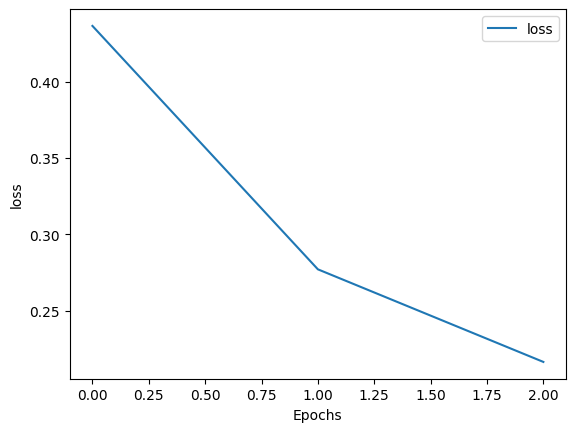

In [62]:
plot_graphs(history, 'loss')

In [63]:
ner_model.save_weights('data_out/KOR/tf2_bert_ner/ner.h5')

In [ ]:
ner_model.load_weights('data_out/KOR/tf2_bert_ner/ner.h5')

In [96]:
def create_inputs(sentence):
    input_ids = []
    attention_masks = []
    token_type_ids = []

    input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

    # print(len(input_id))
    # print(len(attention_mask))
    # print(len(token_type_id))

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    inputs = (input_ids, attention_masks, token_type_ids)

    return inputs

In [110]:
# sentence = '대한민국은 이운재를 시작으로 홍명보, 김주성, 구자철, 박지성, 이동국, 손흥민 등 7명이 48명 후보에 이름을 올렸다.'
sentence = '잉글랜드의 레전드 축구스타 마이클 오언(44)이 소신 발언으로 개막전 위기에 빠진 손흥민(토트넘)을 위로했다.'
inputs = create_inputs(sentence)
print(inputs)

(array([[   101,   9648, 118663,  42771,  10459,   9186,  16617,  15001,
         37905,  12605,  22695,   9246,  10739, 119327,   9580,  48036,
           113,  11126,    114,   9638,   9448,  25387,   9323,  48036,
         11467,   8857, 118907,  16617,   9619,  33797,   9388,  18623,
          9450, 119466,  36553,    113,   9873,  15184, 118732,    114,
          9633,   9619,  11261,  12490,    119,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [111]:
pred = ner_model.predict(inputs)
# print(pred)
pred_argmax = np.argmax(pred, axis = 2)
# print(pred_argmax)

slot_label_map = {i: label for i, label in enumerate(ner_labels)}
# print(slot_label_map)

pred_label = []
for p in pred_argmax[0]:
    # print(p)
    # print(slot_label_map[p])
    pred_label.append(slot_label_map[p])

# print(inputs)
token_print = [tokenizer.decode(token) for token in inputs[0][0]]
print(token_print)
print(pred_label)

1/1 [==============================] - 0s 53ms/step
['[ C L S ]', '잉', '# # 글', '# # 랜 드', '# # 의', '레', '# # 전', '# # 드', '축 구', '# # 스', '# # 타', '마', '# # 이', '# # 클', '오', '# # 언', '(', '4 4', ')', '이', '소', '# # 신', '발', '# # 언', '# # 으 로', '개', '# # 막', '# # 전', '위', '# # 기 에', '빠', '# # 진', '손', '# # 흥', '# # 민', '(', '토', '# # 트', '# # 넘', ')', '을', '위', '# # 로', '# # 했 다', '.', '[ S E P ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]',